In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat

DATASET_DIR = '/media/hcis-s23/c8368b5b-acf1-44ab-9a0c-ab1933a11e2a/TommyLu/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11, 12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v1'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0910_213526'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s23/c8368b5b-acf1-44ab-9a0c-ab1933a11e2a/TommyLu/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s23/c8368b5b-acf1-44ab-9a0c-ab1933a11e2a/TommyLu/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4


/home/hcis-s23/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hcis-s23/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset length: 6019


In [3]:
for batch in loader:
    break

In [5]:
batch['image'].shape

torch.Size([4, 6, 3, 224, 480])

In [7]:
import sys
sys.path.append("../../Depth-Anything-V2")

In [61]:
from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'/media/hcis-s23/c8368b5b-acf1-44ab-9a0c-ab1933a11e2a/TommyLu/Depth-Anything-V2/ckpt/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(device).eval()

In [62]:
# raw_img = cv2.imread('autumn_drive_in_colorado-wallpaper-2560x1440.jpg')
raw_img = batch['image'][0,1].permute(1,2,0).numpy()
raw_img_cv2 = cv2.cvtColor(raw_img * 255, cv2.COLOR_BGR2RGB)
depth = model.infer_image(raw_img_cv2) # HxW raw depth map in numpy

In [ ]:
# shift
# depth = 1. / (shift + (scale * depth))

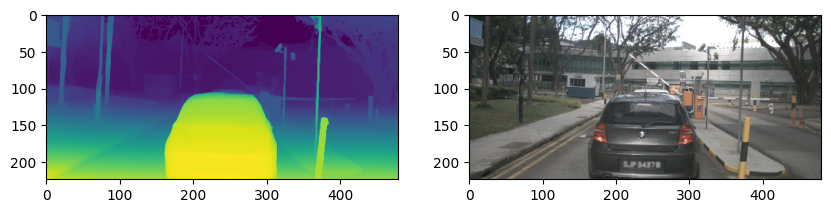

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(depth)
ax2.imshow(raw_img)

In [59]:
np.max(depth)

13.76505

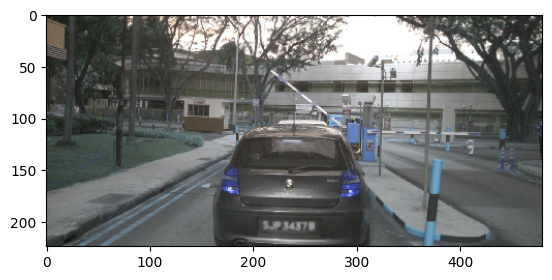

In [46]:
plt.imshow(raw_img)

In [20]:
model

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    